In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [68]:
# 1. Carregar e concatenar arquivos parquet
caminho_pasta = "C:/Users/Colaborador/Documents/repos/gerais/FinSimples/analise/datasets"
arquivos = [os.path.join(caminho_pasta, f) for f in os.listdir(caminho_pasta) if f.endswith('.parquet')]
df = pd.concat([pd.read_parquet(f) for f in arquivos])

# 2. Garantir ordenação e padronização
df['data_pregao'] = pd.to_datetime(df['data_pregao'])
df = df.sort_values(by=['cod_negociacao', 'data_pregao'])

# 3. Função para reamostrar por semana e preservar o código da ação
def semanalizar(grupo):
    df_sem = grupo.resample('W', on='data_pregao').agg({
        'preco_fechamento': 'last',
        'volume': 'sum'
    }).dropna().reset_index()
    df_sem['cod_negociacao'] = grupo['cod_negociacao'].iloc[0]  # Adiciona de volta
    return df_sem

# 4. Aplicar reamostragem por ação
df_semanal = df.groupby('cod_negociacao', group_keys=False).apply(semanalizar)

df_semanal.to_csv("semanal2021-2022.csv", index=False)

df_semanal.head()

C:\Users\Colaborador\AppData\Local\Temp\ipykernel_20120\2496751150.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_semanal = df.groupby('cod_negociacao', group_keys=False).apply(semanalizar)


,data_pregao,preco_fechamento,volume,cod_negociacao
0,2022-02-06,95.84,2101343,5GTK11
1,2022-02-13,92.07,815715,5GTK11
2,2022-02-20,90.55,555884,5GTK11
3,2022-02-27,91.90,1316175,5GTK11
4,2022-03-06,87.10,1002975,5GTK11


In [ ]:
def extrair_features_vetorizado(df_semanal):
    """
    Extrai features de forma vetorizada, muito mais rápido que o loop.
    """
    # Garante que cada grupo de ação está ordenado por data
    df_semanal = df_semanal.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Agrupa por ação para aplicar as funções de janela corretamente
    gb = df_semanal.groupby('cod_negociacao')['preco_fechamento']
    
    # Cria as features usando rolling (janela deslizante)
    df_semanal['media_4w'] = gb.rolling(window=4).mean().reset_index(level=0, drop=True)
    df_semanal['vol_4w'] = gb.rolling(window=4).std().reset_index(level=0, drop=True)
    
    # Para os retornos, usamos shift() para pegar preços passados
    preco_passado_4w = gb.shift(3) # 3 períodos atrás é o início de uma janela de 4 semanas
    preco_passado_12w = gb.shift(11) # 11 períodos atrás é o início de uma janela de 12 semanas
    
    df_semanal['retorno_4w'] = (df_semanal['preco_fechamento'] / preco_passado_4w) - 1
    df_semanal['retorno_12w'] = (df_semanal['preco_fechamento'] / preco_passado_12w) - 1
    
    # A variável alvo já foi criada, então não precisamos recriá-la
    # df_semanal['retorno_futuro'] = gb.shift(-52) / df_semanal['preco_fechamento'] - 1
    
    return df_semanal

# Aplica a nova função
# Primeiro, crie a variável alvo como você já fazia (esse trecho ta criando alguns infinitos)
# Cria a variável alvo evitando divisão por zero ou valores nulos
# Garante que 'cod_negociacao' não esteja no índice
df_semanal = pd.read_csv("semanal2021-2022.csv")

# Criação do retorno futuro
preco_futuro = df_semanal.groupby('cod_negociacao')['preco_fechamento'].shift(-52)
preco_atual = df_semanal['preco_fechamento']

retorno_futuro = np.where(
    (preco_atual.notna()) & (preco_atual != 0),
    (preco_futuro - preco_atual) / preco_atual,
    np.nan
)

df_semanal['retorno_futuro'] = retorno_futuro

# Agora, crie as features de forma otimizada
df_features_otimizado = extrair_features_vetorizado(df_semanal)

# Limpa os NaNs gerados pelas janelas deslizantes e pelo shift do alvo
df_features_otimizado = df_features_otimizado.dropna()

df_features_otimizado.shape

(366037, 9)

In [62]:
# df_features = pd.concat([extrair_features_semanal(g) for _, g in df_semanal.groupby('cod_negociacao')])
df_features_otimizado = df_features_otimizado.reset_index(drop=True)

# 6. Preparar dados para treino
X = df_features_otimizado.drop(columns=['retorno_futuro', 'cod_negociacao', 'data_pregao'])
y = df_features_otimizado['retorno_futuro']

print(X.shape)
print(y.shape)

# Limpeza
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

print(X.shape)
print(y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# mask = y_train < 100_000
# X_train = X_train[mask]
# y_train = y_train[mask]

(366037, 6)
(366037,)
(365949, 6)
(365949,)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# mask = y_train < 100_000
# X_train = X_train[mask]
# y_train = y_train[mask]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [64]:
# Verifique INF/NAN nos dados de teste
print("\nVerificação final antes do MAE:")
print("Infinitos em X_test_scaled:", np.isinf(X_test_scaled).any())
print("NaN em X_test_scaled:", np.isnan(X_test_scaled).any())
print("Infinitos em y_test:", np.isinf(y_test.astype(np.float64)).any())

# Verifique valores extremos
print("\nValores extremos:")
print("Max y_test:", y_test.max())
print("Min y_test:", y_test.min())


Verificação final antes do MAE:
Infinitos em X_test_scaled: False
NaN em X_test_scaled: False
Infinitos em y_test: False

Valores extremos:
Max y_test: 2579.0
Min y_test: -1.0


In [65]:
# 7. Treinar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Infinitos em y_pred:", np.isinf(y_pred).any())
print("Max y_pred:", y_pred.max())
print("Min y_pred:", y_pred.min())

# mae = mean_absolute_error(y_test, y_pred)
# print(f"MAE (erro absoluto médio): {mae:.4f}")

Infinitos em y_pred: False
Max y_pred: 1797.685
Min y_pred: -0.9141011190643771


In [66]:
from sklearn.metrics import mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE (erro absoluto médio): {mae:.4f}")
print("R²:", r2_score(y_test, y_pred))

MAE (erro absoluto médio): 0.8464
R²: -1.5875807479095019


📊 Regressão Linear:
MAE: 0.3889592900861765
RMSE: 1.171466318197231
R²: -0.009095217836476044


C:\Users\Colaborador\AppData\Local\Temp\ipykernel_20120\2824181757.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Colaborador\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


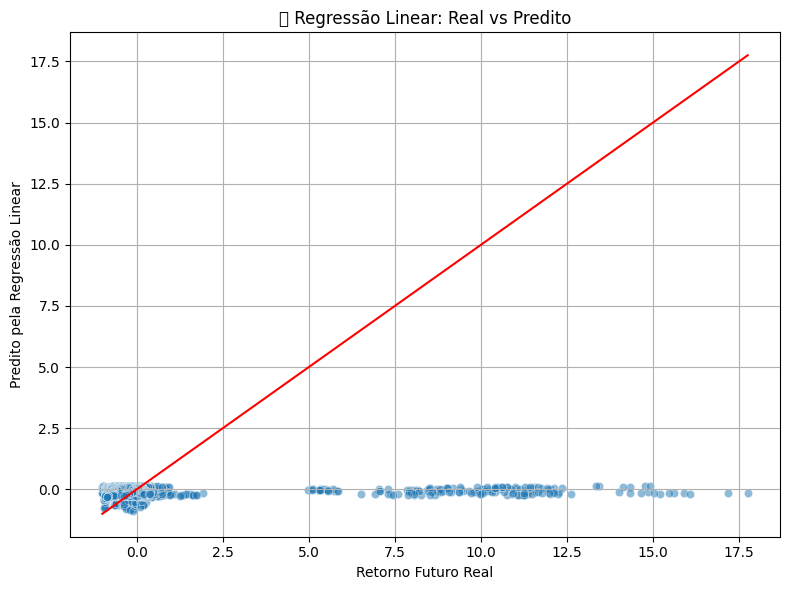

In [58]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
# 7. Treinar modelo de regressão linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 8. Prever
y_pred_lr = lr_model.predict(X_test)

# 9. Avaliar
print("📊 Regressão Linear:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R²:", r2_score(y_test, y_pred_lr))

# 10. Visualização
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5)
plt.xlabel("Retorno Futuro Real")
plt.ylabel("Predito pela Regressão Linear")
plt.title("📈 Regressão Linear: Real vs Predito")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# 9. Função para prever nova ação com últimas 12 semanas
def prever_retorno_semanal(df_semanal, ticker, data_referencia):
    df_ticker = df_semanal[df_semanal['cod_negociacao'] == ticker].sort_values('data_pregao')
    janela = df_ticker[df_ticker['data_pregao'] <= data_referencia].tail(12)
    if len(janela) < 12:
        raise ValueError("Não há dados suficientes (12 semanas) antes da data")
    
    entrada = {
        'media_4w': janela['preco_fechamento'].tail(4).mean(),
        'volatilidade_4w': janela['preco_fechamento'].tail(4).std(),
        'retorno_4w': janela['preco_fechamento'].iloc[-1] / janela['preco_fechamento'].iloc[-4] - 1,
        'retorno_12w': janela['preco_fechamento'].iloc[-1] / janela['preco_fechamento'].iloc[0] - 1,
        'volume_medio': janela['volume'].mean(),
    }
    entrada_df = pd.DataFrame([entrada])
    retorno_previsto = model.predict(entrada_df)[0]
    return retorno_previsto * 100  # em %

# 10. Exemplo de uso
ticker_exemplo = 'PETR4'
data_exemplo = pd.Timestamp('2023-06-01')
retorno_percentual = prever_retorno_semanal(df_semanal, ticker_exemplo, data_exemplo)
print(f"Previsão de rendimento médio em 1 ano para {ticker_exemplo} a partir de {data_exemplo.date()}: {retorno_percentual:.2f}%")


TypeError: '<=' not supported between instances of 'str' and 'Timestamp'